In [1]:
f_func <- "./functions.ipynb"
eval(parse(text = system2('jupyter', c('nbconvert', f_func, '--to=script', '--stdout'), stdout = TRUE)))

f_data_loading <- "./data_loading.ipynb"
eval(parse(text = system2('jupyter', c('nbconvert', f_data_loading, '--to=script', '--stdout'), stdout = TRUE)))

Loading required package: Rsamtools

Loading required package: GenomeInfoDb

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: Biostrings



The following objects are masked from ‘package:stats’:

    as.dist, dist


The following object is masked from ‘package:base’:

    as.matrix


Warning message:
“no DISPLAY variable so Tk is not available”
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loaded TSdist v3.7.1. See ?TSdist for help, citation("TSdist") for use in publication.


Loading required package: dtplyr

Loading required package: profvis

Loading required package: ggforce

Loading required package: pracma


Attaching package: ‘pracma’


The following object is masked from ‘package:purrr’:

    cross


The following object is masked from ‘package:Hmisc’:

    ceil


Loading required package: rstatix


Attaching package: ‘rstatix’


The following object is masked from ‘package:IRanges’:

    desc


The following object is masked from ‘package:stats’:

    filter


Loading required package: ggpubr

Loading required package: jsonlite


Attaching package: ‘jsonlite’


T

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


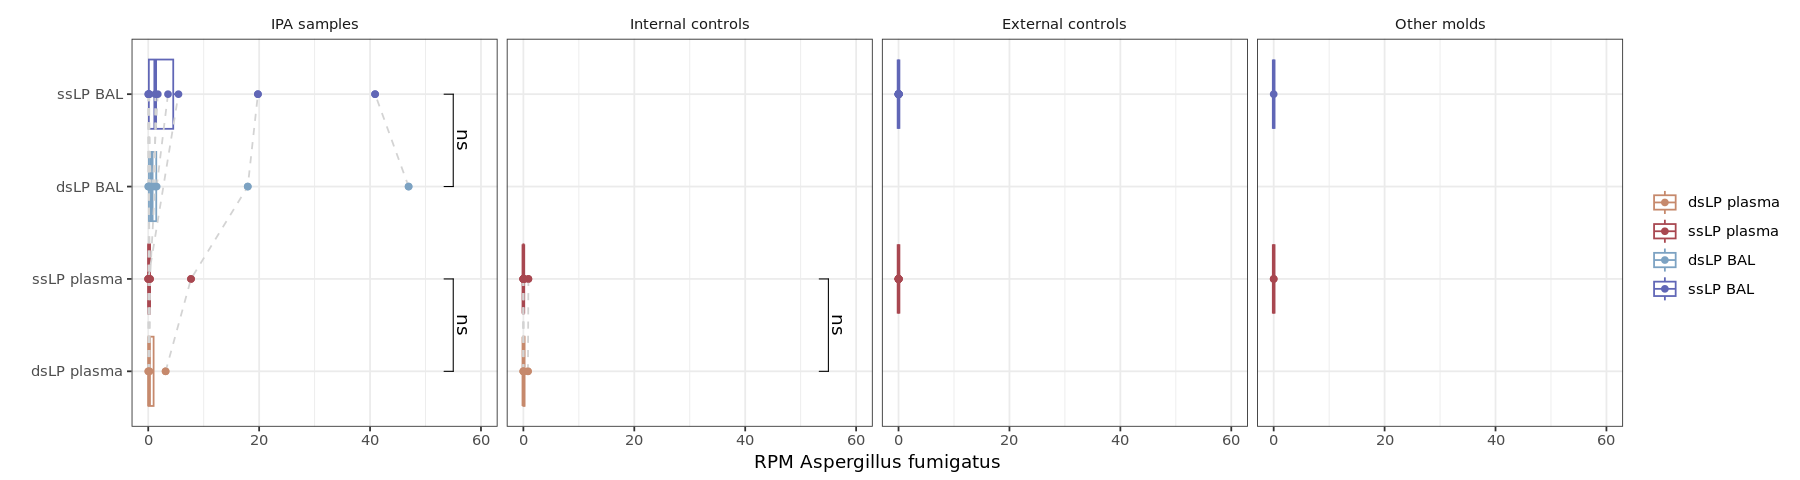

In [77]:
options(repr.plot.width=15, repr.plot.height=4)
combined_data <- rbind(plasma_sizeSelection_meta, BAL_sizeSelection_meta) 
data_RPM_Afum <- combined_data %>%
    filter(sample != "control") %>% 
    filter(taxName == "Aspergillus fumigatus") %>%
    filter(new_Filter == "noFilter") %>% 
    #filter(origin == "IPA samples") %>% 
    mutate(RPM = taxID_number_reads/QC_number_reads*10^6) %>% 
    mutate(sample_type = factor(sample_type, 
                                levels = c('dsLP plasma','ssLP plasma', 'dsLP BAL', 'ssLP BAL'))) %>% 
    mutate(origin = factor(origin, 
                    levels = c('IPA samples', 'Internal controls', 'External controls', 'Other molds')))

stats_RPM_Afum <- compare_means(data_RPM_Afum, 
                           formula = RPM~sample_type, group.by = c("origin"), 
                           method = "wilcox.test",
                           p.adjust.method = "bonferroni") %>% 
    filter(group1 == "dsLP plasma" & group2 == "ssLP plasma" | 
           group1 == "dsLP BAL" & group2 == "ssLP BAL")

fig_RPM_Afum <- data_RPM_Afum %>% 
    ggplot(aes(y = RPM, x = sample_type)) +   
        geom_boxplot(aes(col = sample_type)) + 
        geom_line(aes(group = patient), col = "lightgrey", linetype = 2) + 
        geom_point(aes(col = sample_type)) + 
        stat_pvalue_manual(stats_RPM_Afum, y.position = rep(55), 
                        label = "p.signif",remove.bracket = FALSE, coord.flip = TRUE,) +
        facet_grid(cols = vars(origin)) + 
        scale_color_manual(values = c("dsLP plasma" = "#C6896C", "ssLP plasma" = "#A84750", 
                                 "dsLP BAL" = "#7CA2C2", "ssLP BAL" = "#6066B6")) + 
        ylim(0,60) + theme_bw() + 
        theme(strip.background = element_blank()) + 
        labs(y = "RPM Aspergillus fumigatus", x = "", col = "") + coord_flip()

fig_RPM_Afum %>% print()
ggsave(paste0("../../output_figures/Afumigatus_RPM.png"), plot = fig_RPM_Afum, 
               width = 15, height = 4)
ggsave(paste0("../../output_figures/Afumigatus_RPM.pdf"), plot = fig_RPM_Afum, 
               width = 15, height = 4)

In [3]:
data_RPM_Afum %>% 
    group_by(sample_type, origin) %>% 
    summarise(
        Q1 = round(quantile(RPM, probs = 0.25, na.rm = TRUE), digits = 2),
        median = round(median(RPM, na.rm = TRUE), digits = 2),
        Q3 = round(quantile(RPM, probs = 0.75, na.rm = TRUE), digits = 2),
    ) %>% filter(origin == 'IPA samples') %>% filter(grepl(sample_type, pattern = 'ssLP'))

`summarise()` has grouped output by 'sample_type'. You can override using the `.groups` argument.


sample_type,origin,Q1,median,Q3
<fct>,<fct>,<dbl>,<dbl>,<dbl>
ssLP plasma,IPA samples,0.00,0.16,0.32
ssLP BAL,IPA samples,0.11,1.26,4.51


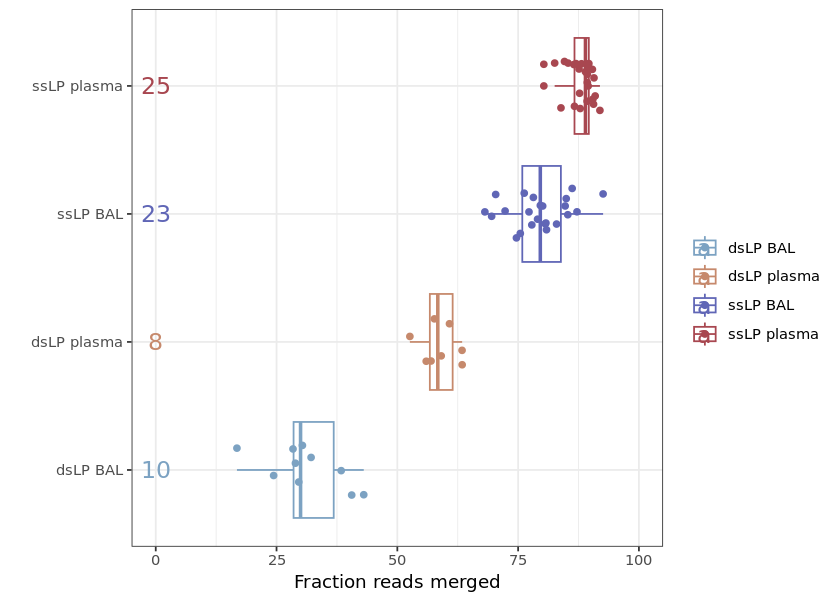

In [84]:
options(repr.plot.width=7, repr.plot.height=5)
# Assuming plasma_sizeSelection_meta and BAL_sizeSelection_meta are already defined data frames
combined_data <- rbind(plasma_sizeSelection_meta, BAL_sizeSelection_meta) 

# Data manipulation
summary_data <- combined_data %>%
  filter(sample != "control") %>% 
  filter(taxName == "Aspergillus fumigatus") %>%
  filter(new_Filter %in% c("noFilter", "35-1000")) %>%     
  select(-taxID_number_reads, -Filter) %>% 
  pivot_wider(names_from = new_Filter, values_from = QC_number_reads, names_prefix = "QC#_") %>% 
  mutate(fraction_merged = `QC#_35-1000` / `QC#_noFilter` * 100)

# Calculate number of data points for each sample_type
sample_sizes <- summary_data %>%
  group_by(sample_type) %>%
  summarise(count = n(), .groups = "drop")

# Create the box plot with sample sizes
ss_perc_merged <- ggplot(summary_data, aes(x = sample_type, y = fraction_merged, col = sample_type)) + 
  geom_boxplot() + 
  geom_jitter(width = 0.2) + 
  geom_text(data = sample_sizes, aes(x = sample_type, y = 0, label = count), 
            vjust = 0.5, # Adjust vertical position of the labels
            size = 5) +  # Adjust size of the text
  scale_color_manual(values = c("dsLP plasma" = "#C6896C", "ssLP plasma" = "#A84750", 
                                 "dsLP BAL" = "#7CA2C2", "ssLP BAL" = "#6066B6")) + 
  theme_bw() + 
  labs(y = "Fraction reads merged", x = "", color = "") + 
  ylim(0, 100) + coord_flip()

ss_perc_merged %>% print()
ggsave(paste0("../../output_figures/sizeSelection_perc_reads_merged.png"), plot = ss_perc_merged, 
               width = 7, height = 5)
ggsave(paste0("../../output_figures/sizeSelection_perc_reads_merged.pdf"), plot = ss_perc_merged, 
               width = 7, height = 5)

In [90]:
data_ss_RPM %>% filter(sample_id == "A12Basp")

sample_id,sample_type,origin,patient,variable,value,unique_sample_ids,label_new
<chr>,<chr>,<fct>,<chr>,<fct>,<dbl>,<int>,<chr>
A12Basp,ssLP BAL,IPA samples,A12,35-50,0.000000,11,IPA samples (n = 11)
A12Basp,ssLP BAL,IPA samples,A12,35-75,14.099304,11,IPA samples (n = 11)
A12Basp,ssLP BAL,IPA samples,A12,35-100,7.478412,11,IPA samples (n = 11)
A12Basp,ssLP BAL,IPA samples,A12,35-125,3.735494,11,IPA samples (n = 11)
A12Basp,ssLP BAL,IPA samples,A12,35-150,2.976606,11,IPA samples (n = 11)


Warning message:
“Removed 57 rows containing missing values or values outside the scale range (`geom_text()`).”
Warning message:
“Removed 57 rows containing missing values or values outside the scale range (`geom_text()`).”
Warning message:
“Removed 57 rows containing missing values or values outside the scale range (`geom_text()`).”


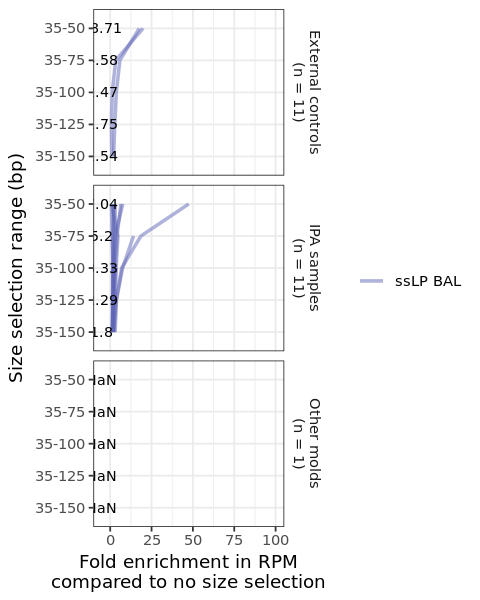

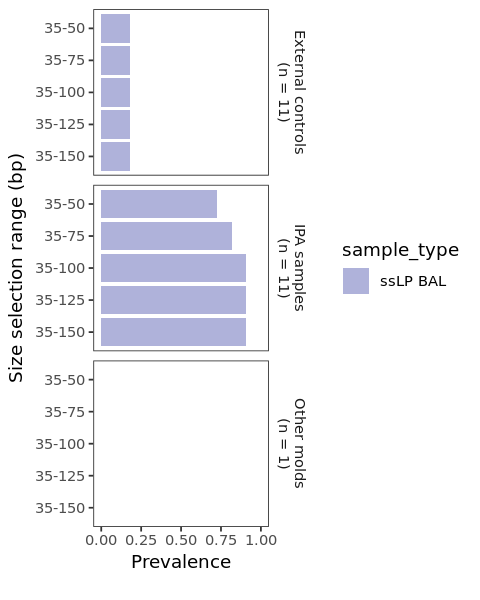

In [86]:
# Prepare the data
for (sel_sample in c("plasma", "BAL")[2]){
    for (tmp_type in c("ssLP", "dsLP")[1]){
        if (tmp_type == "ssLP"){max_xaxis = 100}
        if (tmp_type == "dsLP"){max_xaxis = 65}
        data_ss_RPM <- rbind(plasma_sizeSelection_meta, BAL_sizeSelection_meta) %>%
            filter(taxName == "Aspergillus fumigatus") %>%
            filter(sample == sel_sample) %>% 
            filter(type == tmp_type) %>% 
            mutate(
                RPM = ifelse(QC_number_reads != taxID_number_reads, 
                             taxID_number_reads / QC_number_reads * 10^6, 
                             NA),  # Calculating RPM
                taxID_number_reads = ifelse(taxID_number_reads == QC_number_reads, NA, taxID_number_reads)
            ) %>%
            filter(!is.na(RPM)) %>%
            select(sample_id, new_Filter, RPM, sample_type, origin, patient) %>% 
            filter(new_Filter != "35-1000") %>%    
            pivot_wider(names_from = new_Filter, values_from = RPM, names_prefix = "RPM_") %>%
            #filter(RPM_noFilter != 0) %>% 
            mutate(across(starts_with("RPM_"), ~ .x / RPM_noFilter)) %>%
            pivot_longer(cols = starts_with("RPM_"), names_to = "variable", values_to = "value") %>%
            filter(variable != "RPM_noFilter") %>%
            mutate(variable = gsub("RPM_", "", variable)) %>% 
            mutate(variable = factor(variable, levels = rev(c('35-50','35-75','35-100','35-125','35-150')))) %>% 
            mutate(origin = factor(origin, 
                    levels = c('IPA samples', 'Internal controls', 'External controls', 'Other molds'))) %>%
            group_by(origin) %>%
            mutate(unique_sample_ids = n_distinct(sample_id)) %>% 
            mutate(label_new = paste0(origin, "\n(n = ", unique_sample_ids, ")"))

        # Create the plot
        ss_foldEnrichment <- data_ss_RPM  %>% 
            ggplot(aes(x = value, y = variable)) + 
                #geom_point(data = . %>% filter(value != 0) %>% mutate(value = ifelse(value > 100, yes = Inf, no = value)), 
                #        aes(col = sample_type) , 
                #           size = 1.5, alpha = 0.5) +  # Adding jitter to avoid overlap
                geom_path(data = . %>% filter(value != 0), 
                        aes(group = sample_id, col = sample_type), linewidth = 1, alpha = 0.5) + 
                geom_text(data = data_ss_RPM %>% group_by(sample_type, variable, label_new) %>% 
                            summarise(tmp_lbl = paste0(label = round(mean(value, na.rm = TRUE), digits = 2)),  # Ratio of non-zero to total values
                                  .groups = "keep"), 
                          aes(x = -5, label = tmp_lbl), color = "black", size = 3) + 
                geom_text(data = . %>% filter(value != 0) %>% mutate(tmp_lbl2 = ifelse(value > 100, yes = round(value, digits = 0), no = NA)), 
                          aes(x = Inf, label = tmp_lbl2), col = "#A84750", size = 3, hjust = 1.5) + 
                scale_color_manual(values = c("dsLP plasma" = "#C6896C", "ssLP plasma" = "#A84750", 
                                              "dsLP BAL" = "#7CA2C2", "ssLP BAL" = "#6066B6")) +
                theme_bw() + 
                facet_grid(rows = vars(label_new)) + 
                labs(x = "Fold enrichment in RPM\ncompared to no size selection", 
                     y = "Size selection range (bp)", color = "", shape = "") + 
                theme(
                    strip.background = element_blank(),  # Remove background of facet labels
                    #strip.text = element_blank()# Remove facet label text
                ) + 
                xlim(-5, max_xaxis) 
        
        options(repr.plot.width = 4, repr.plot.height = 9)
        ss_prevalence <- data_ss_RPM %>% 
            group_by(origin) %>%
            mutate(unique_sample_ids = n_distinct(sample_id)) %>% 
            mutate(label_new = paste0(origin, "\n(n = ", unique_sample_ids, ")")) %>% 
            group_by(sample_type, variable, label_new) %>% 
            summarise(prevalence = sum(value != 0, na.rm = TRUE)/n(), .groups = "keep") %>% 
            ggplot(aes(x = prevalence, y = variable, fill = sample_type), col = NA) + 
                geom_bar(position=position_dodge(width=0.1), stat="identity", alpha = 0.5) + 
                theme_bw() + 
                facet_grid(rows = vars(label_new)) + 
                labs(x = "Prevalence\n", y = "Size selection range (bp)") + 
                scale_fill_manual(values = c("dsLP plasma" = "#C6896C", "ssLP plasma" = "#A84750", 
                                              "dsLP BAL" = "#7CA2C2", "ssLP BAL" = "#6066B6")) + 
                theme(
                    strip.background = element_blank(),  
                    panel.grid.minor = element_blank(), 
                    panel.grid.major = element_blank()
                    #strip.text = element_blank()# Remove facet label text
                ) + xlim(0,1)
        
        tmp_uniq_origin = data_ss_RPM$origin %>% unique() %>% length()
        tmp_height = c(1.5*tmp_uniq_origin+0.5)
        
        ggsave(paste0("../../output_figures/sizeSelection_foldEnrichment_", tmp_type, "_", sel_sample, ".png"), plot = ss_foldEnrichment, 
                        width = 8, height = tmp_height)
        ggsave(paste0("../../output_figures/sizeSelection_foldEnrichment_", tmp_type, "_", sel_sample, ".pdf"), plot = ss_foldEnrichment, 
                        width = 8, height = tmp_height)
        
        ggsave(paste0("../../output_figures/sizeSelection_prevalence_", tmp_type, "_", sel_sample, ".png"), plot = ss_prevalence, 
                        width = 4, height = tmp_height)
        ggsave(paste0("../../output_figures/sizeSelection_prevalence_", tmp_type, "_", sel_sample, ".pdf"), plot = ss_prevalence, 
                           width = 4, height = tmp_height)

        options(repr.plot.width = 8, repr.plot.height = tmp_height)
        ss_foldEnrichment %>% print()
        
        options(repr.plot.width = 4, repr.plot.height = tmp_height)
        ss_prevalence %>% print()
    }
}


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message in scale_x_log10(limits = c(min_RPM, max_RPM)):
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10(limits = c(min_RPM, max_RPM)):
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message in scale_x_log10(limits = c(min_RPM, max_RPM)):
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10(limits = c(min_RPM, max_RPM)):
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message in scale_x_log10(limits = c(min_RPM, max_RPM)):
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10(limits = c(min_RPM, max_RPM)):
“log-10 trans

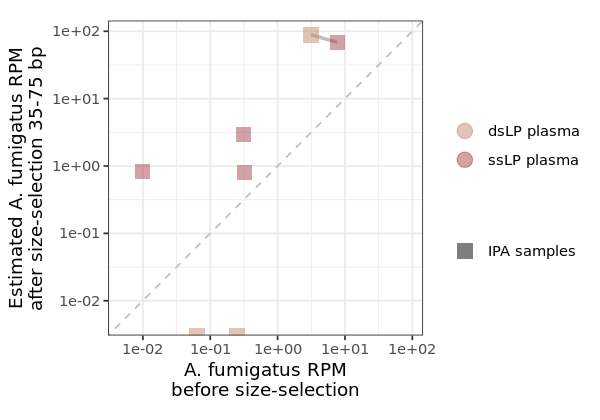

In [6]:
options(repr.plot.width=5, repr.plot.height=3.5)
ss_readRatio_plasma_data <- plasma_sizeSelection_meta %>%
    filter(taxName == "Aspergillus fumigatus") %>%
    mutate(
        RPM = ifelse(QC_number_reads != taxID_number_reads, 
                     taxID_number_reads / QC_number_reads * 10^6, 
                     NA),  # Calculating RPM
        taxID_number_reads = ifelse(taxID_number_reads == QC_number_reads, NA, taxID_number_reads)
    ) %>%
    filter(!is.na(RPM)) %>%
    select(sample_id, new_Filter, RPM, sample_type, origin, patient, type) %>% 
    filter(new_Filter %in% c("noFilter", "35-75")) %>%     
    pivot_wider(names_from = new_Filter, values_from = RPM, names_prefix = "RPM_") 

# Find the max value for both axes
max_RPM <- max(ss_readRatio_plasma_data$RPM_noFilter, ss_readRatio_plasma_data$`RPM_35-75`, na.rm = TRUE)
min_RPM <- min(ss_readRatio_plasma_data$RPM_noFilter[which(ss_readRatio_plasma_data$RPM_noFilter != 0)], 
               ss_readRatio_plasma_data$`RPM_35-75`[which(ss_readRatio_plasma_data$`RPM_35-75` != 0)], na.rm = TRUE)

# Plot with equal x and y limits
ss_scatter_readRatio_plasma <- ss_readRatio_plasma_data %>%
    filter(origin == "IPA samples") %>% 
    ggplot(aes(x = RPM_noFilter, y = `RPM_35-75`, shape = origin, group = patient)) +   # Use backticks to reference column name with "-"
        geom_line(data = . %>% filter(`RPM_35-75` != 0) %>% filter(RPM_noFilter != 0),
                  aes(group = interaction(patient)), col = "grey", size = 1, linetype = 1, alpha = 1) +
        geom_point(aes( col = sample_type), size = 4, alpha = 0.5) +  # Scatter plot of RPM comparison
        geom_abline(slope = 1, intercept = 0, linetype = "dashed", col = "grey") +  # Add a dashed y=x line
        scale_color_manual(values = c("dsLP plasma" = "#C6896C", "ssLP plasma" = "#A84750", 
                                      "dsLP BAL" = "#7CA2C2", "ssLP BAL" = "#6066B6")) + 
        scale_shape_manual(values = c("IPA samples" = 15, 
                                       "External controls" = 16, 
                                       "Internal controls" = 17)) +
        labs(
            y = "Estimated A. fumigatus RPM\nafter size-selection 35-75 bp", 
            x = "A. fumigatus RPM\nbefore size-selection",
            color = "", shape = ""
        ) + coord_equal() + 
        scale_x_log10(limits = c(min_RPM, max_RPM)) +  # Set log10 scale with x-axis limits
        scale_y_log10(limits = c(min_RPM, max_RPM)) + 
        theme_bw()

ss_scatter_readRatio_plasma %>% print()
ggsave(paste0("../../output_figures/sizeSelection_scatter_plasma.png"), plot = ss_scatter_readRatio_plasma, 
               width = 5, height = 3.5)
ggsave(paste0("../../output_figures/sizeSelection_scatter_plasma.pdf"), plot = ss_scatter_readRatio_plasma, 
               width = 5, height = 3.5)

Warning message in scale_x_log10(limits = c(min_RPM, max_RPM)):
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10(limits = c(min_RPM, max_RPM)):
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message in scale_x_log10(limits = c(min_RPM, max_RPM)):
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10(limits = c(min_RPM, max_RPM)):
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message in scale_x_log10(limits = c(min_RPM, max_RPM)):
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10(limits = c(min_RPM, max_RPM)):
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 2 rows containing missing values or values outside the

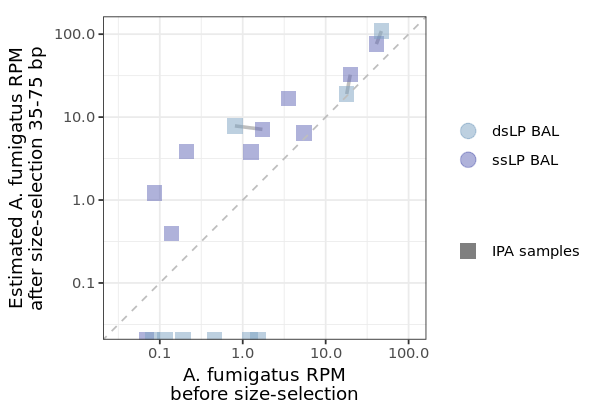

In [7]:
options(repr.plot.width=5, repr.plot.height=3.5)
ss_readRatio_BAL_data <- BAL_sizeSelection_meta %>%
    filter(taxName == "Aspergillus fumigatus") %>%
    mutate(
        RPM = ifelse(QC_number_reads != taxID_number_reads, 
                     taxID_number_reads / QC_number_reads * 10^6, 
                     NA),  # Calculating RPM
        taxID_number_reads = ifelse(taxID_number_reads == QC_number_reads, NA, taxID_number_reads)
    ) %>%
    filter(!is.na(RPM)) %>%
    select(sample_id, new_Filter, RPM, sample_type, origin, patient, type) %>% 
    filter(new_Filter %in% c("noFilter", "35-75")) %>%     
    pivot_wider(names_from = new_Filter, values_from = RPM, names_prefix = "RPM_") 

# Find the max value for both axes
max_RPM <- max(ss_readRatio_BAL_data$RPM_noFilter, ss_readRatio_BAL_data$`RPM_35-75`, na.rm = TRUE)
min_RPM <- min(ss_readRatio_BAL_data$RPM_noFilter[which(ss_readRatio_BAL_data$RPM_noFilter != 0)], 
               ss_readRatio_BAL_data$`RPM_35-75`[which(ss_readRatio_BAL_data$`RPM_35-75` != 0)], na.rm = TRUE)

# Plot with equal x and y limits
ss_scatter_readRatio_BAL <- ss_readRatio_BAL_data %>%
    filter(origin == "IPA samples") %>% 
    ggplot(aes(x = RPM_noFilter, y = `RPM_35-75`, col = sample_type, shape = origin, group = patient)) +   # Use backticks to reference column name with "-"
        geom_line(data = . %>% filter(`RPM_35-75` != 0) %>% filter(RPM_noFilter != 0),
                  aes(group = interaction(patient)), col = "grey", size = 1, linetype = 1, alpha = 1) +
        geom_point(size = 4, alpha = 0.5) +  # Scatter plot of RPM comparison
        geom_abline(slope = 1, intercept = 0, linetype = "dashed", col = "grey") +  # Add a dashed y=x line
        scale_color_manual(values = c("dsLP plasma" = "#C6896C", "ssLP plasma" = "#A84350", 
                                      "dsLP BAL" = "#7CA2C2", "ssLP BAL" = "#6066B6")) + 
        scale_shape_manual(values = c("IPA samples" = 15, 
                                       "External controls" = 16, 
                                       "Internal controls" = 17)) + 
        labs(
            y = "Estimated A. fumigatus RPM\nafter size-selection 35-75 bp", 
            x = "A. fumigatus RPM\nbefore size-selection",
            color = "", shape = ""
        ) + coord_equal() + 
        scale_x_log10(limits = c(min_RPM, max_RPM)) +  # Set log10 scale with x-axis limits
        scale_y_log10(limits = c(min_RPM, max_RPM)) + 
        theme_bw()

ss_scatter_readRatio_BAL %>% print()
ggsave(paste0("../../output_figures/sizeSelection_scatter_BAL.png"), plot = ss_scatter_readRatio_BAL, 
               width = 5, height = 3.5)
ggsave(paste0("../../output_figures/sizeSelection_scatter_BAL.pdf"), plot = ss_scatter_readRatio_BAL, 
               width = 5, height = 3.5)

In [8]:
ss_readRatio_BAL_data %>%
    filter(origin == "IPA samples") %>%
    summarise(
        Q1_noFilter = quantile(RPM_noFilter, probs = 0.25, na.rm = TRUE),
        median_noFilter = median(RPM_noFilter, na.rm = TRUE),
        Q3_noFilter = quantile(RPM_noFilter, probs = 0.75, na.rm = TRUE),
        Q1_RPM_35_100 = quantile(`RPM_35-75`, probs = 0.25, na.rm = TRUE),
        median_RPM_35_100 = median(`RPM_35-75`, na.rm = TRUE),
        Q3_RPM_35_100 = quantile(`RPM_35-75`, probs = 0.75, na.rm = TRUE)
    )

Q1_noFilter,median_noFilter,Q3_noFilter,Q1_RPM_35_100,median_RPM_35_100,Q3_RPM_35_100
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.1160837,0.8045796,3.566218,0,3.791856,12.23344


In [9]:
ss_readRatio_plasma_data %>%
    filter(origin == "IPA samples") %>%
    summarise(
        Q1_noFilter = quantile(RPM_noFilter, probs = 0.25, na.rm = TRUE),
        median_noFilter = median(RPM_noFilter, na.rm = TRUE),
        Q3_noFilter = quantile(RPM_noFilter, probs = 0.75, na.rm = TRUE),
        Q1_RPM_35_75 = quantile(`RPM_35-75`, probs = 0.25, na.rm = TRUE),
        median_RPM_35_75 = median(`RPM_35-75`, na.rm = TRUE),
        Q3_RPM_35_75 = quantile(`RPM_35-75`, probs = 0.75, na.rm = TRUE)
    )

Q1_noFilter,median_noFilter,Q3_noFilter,Q1_RPM_35_75,median_RPM_35_75,Q3_RPM_35_75
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.002488463,0.1565773,0.3203258,0.3975982,0.8204953,35.78437
